In [ ]:
### import pandas as pd
import numpy as np 
import altair as alt
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt  
import os
from urllib.request import urlopen
import zipfile
import warnings

pd.set_option('display.float_format', '{:.2f}'.format)
pd.set_option('display.max_columns', None)
warnings.filterwarnings('ignore')
#NOTE only need below change to altair rendering to have static altair images render on github 
#b/c github scrubs javascript CAN REMOVE if running locally
#Also, if you do want this to work for some reason, need to have selenium/chromedriver installed 
alt.renderers.enable('altair_saver', fmts=['vega-lite', 'png'])

### The code below examines the differences between published 2010 decennial census data vs. the same data had the Census Bureau's new differentially private algorithm been applied to it

The check_for_download function will check to see if the block group level CSV exists for the 2021-06-08 Privacy Protected 2010 Census Demonstration Data in the users current directory, and download it from IPUMS if not. David Van Riper, Tracy Kugler, and Jonathan Schroeder. IPUMS NHGIS Privacy-Protected 2010 Census Demonstration Data, version 20210608 [Database]. Minneapolis, MN: IPUMS. 2020. https://www.nhgis.org/privacy-protected-2010-census-demonstration-data#v20210608 

In [2]:
def check_for_download(filename,zip_location,zip_name):
    """
    inputs:
        filename (str) - name of csv downloaded 
        zip_location (str) - location of zip file 
        zip_name (str) - name of the zip file downloaded from the zip location to open 
        
    Here checking to see if the data is in the current directory, if not, downloading and unzipping 
    it to the current directory (can place is somewhere else by modifying filepath of zip_directory)
    """
    if os.path.isfile(filename):
        df = pd.read_csv(filename)
        return df
    else:
        zip_directory = os.getcwd()
        url = urlopen(zip_location)
        output = open(zip_name, 'wb')           
        output.write(url.read())
        output.close()
        with zipfile.ZipFile(zip_name, 'r') as zip_ref:
            zip_ref.extractall(zip_directory)
        df = pd.read_csv(filename)
    return df
df = check_for_download("nhgis_ppdd_20210608_blck_grp.csv","https://assets.nhgis.org/differential-privacy/v20210608/nhgis_ppdd_20210608_blck_grp.zip","nhgis_ppdd_20210608_blck_grp.zip")

In [3]:
#The census only starts to make reliability claims at block groups bigger than 550
#so filtering out block groups with a population 550 or below 
df_big = df[df["H72001_dp"] >550]

In [4]:
#rearrrange data for analysis - note this will take 10+ minutes to run
ca = df_big.melt(id_vars=['gisjoin', 'name', 'state'])
ca['code'] = ca.variable.apply(lambda x: x.split('_')[0])
ca['method'] = ca.variable.apply(lambda x: x.split('_')[1])
ca = ca.pivot_table(index=['gisjoin', 'name', 'state', 'code'], columns='method', values=['value']).reset_index()
ca.columns = ['gisjoin', 'name', 'state', 'code', 'dp_value', 'sf_value']

#calculate the percent change (and its absolute value) between the two meathods
ca['pct_change'] = ((ca.dp_value - ca.sf_value)/ca.sf_value)*100
ca["pct_change_absolute_value"] = np.abs(ca["pct_change"])
#drop cases where this can't be calculated 
ca.replace([np.inf, -np.inf], np.nan, inplace=True)
ca = ca.dropna(subset=["pct_change"], how="all")
#calculate total value changes 
ca["total_difference"] = ca["dp_value"] - ca["sf_value"]
ca["total_difference_absolute_value"] = np.abs(ca["total_difference"]) 

In [5]:
#subset to total population counts, as well as by a few large racial categories 
total = ca[ca.code == "H72001"]
black = ca[ca.code == "H72004"]
asian= ca[ca.code=="H72006"]
white= ca[ca.code=="H73005"]

In [6]:
def check_thresholds(df, bins,labels,race):
    df["Population Bins"]= pd.cut(df['sf_value'], bins=cut_bins,labels=cut_labels)
    df_percent_change = df.groupby("Population Bins").agg(['mean','std']).reset_index()
    
    #flatten col names 
    df_percent_change.columns = [' '.join(col).strip() for col in df_percent_change.columns.values]
    
    #make upper and lower bound with std for charting
    df_percent_change["lower_bound_pct_change"] = df_percent_change["pct_change_absolute_value mean"] - df_percent_change["pct_change_absolute_value std"]
    df_percent_change["upper_bound_pct_change"] = df_percent_change["pct_change_absolute_value mean"] + df_percent_change["pct_change_absolute_value std"]

    df_percent_change["lower_bound_total_value"] = df_percent_change["total_difference_absolute_value mean"] - df_percent_change["total_difference_absolute_value std"]
    df_percent_change["upper_bound_total_value"] = df_percent_change["total_difference_absolute_value mean"] + df_percent_change["total_difference_absolute_value std"]                                                                     
    df_percent_change["race"] = race 
    
    return df_percent_change

In [7]:
cut_bins = [0, 25, 50, 150,350, 3372.00]
cut_labels = ['0-25', '25-50', '50-150', "150-350","350+"]

black_percent_change = check_thresholds(black,cut_bins,cut_labels,"Black")
asian_percent_change = check_thresholds(asian,cut_bins,cut_labels,"Asian")
nh_white_percent_change = check_thresholds(white,cut_bins,cut_labels,"Non-Hispanic White")

In [8]:
total["Population"] = "Total Population"
black["Population"] = "Total Black Population"
asian["Population"] = "Total Asian Population"
white["Population"] = "Total Non-Hispanic White Population"
overall = pd.concat([total, black, asian, white])
#label block groups with deviations greater than X percent 
overall["Percent of Block Groups > 5% Different"] = np.where(overall["pct_change_absolute_value"]>5,1,0)
overall["Percent of Block Groups > 1% Different"] = np.where(overall["pct_change_absolute_value"]>1,1,0)

overall = overall[["Population","Percent of Block Groups > 5% Different","Percent of Block Groups > 1% Different"]].groupby("Population").mean().reset_index()
overall[["Percent of Block Groups > 5% Different","Percent of Block Groups > 1% Different"]] = overall[["Percent of Block Groups > 5% Different","Percent of Block Groups > 1% Different"]]  * 100
#reshape for graphing 
overall = overall.melt(id_vars="Population")

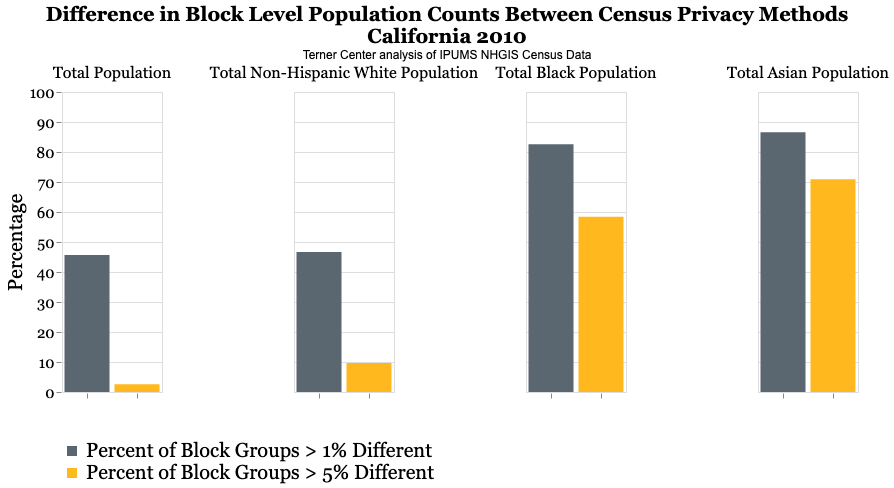

In [15]:
#Figure 1 
alt.Chart(overall).mark_bar().encode(
    alt.X('variable:O',title=" ", axis=alt.Axis(labels=False)),
    alt.Y('value',title="Percentage", scale=alt.Scale(domain=[0, 100])),color=alt.Color('variable:O',title="",scale=alt.Scale(domain=['Percent of Block Groups > 1% Different',"Percent of Block Groups > 5% Different"],
                              range=['#5B6770','#FFB81D',])),
    column=alt.Column('Population',title="",spacing=130,sort=['Total Population',"Total Non-Hispanic White Population","Total Black Population","Total Asian Population"], header=alt.Header(labelFontSize=16,labelFont="Georgia")),
                    ).properties(
    title={
      "text": ["Difference in Block Level Population Counts Between Census Privacy Methods"," California 2010"],
    "subtitle":["Terner Center analysis of IPUMS NHGIS Census Data"]}).configure_title(fontSize=20,anchor="middle",font="Georgia").configure_legend(direction="vertical",labelLimit= 0,titleLimit=0,titleFontSize=18,
labelFontSize=20,labelFont="Georgia",titleFont="Georgia",orient="bottom").configure_axis(domain=False,labelFont='Georgia',titleFont='Georgia',titleFontWeight="normal",labelFontSize=15,titleFontSize=20).properties(
    width=100
)

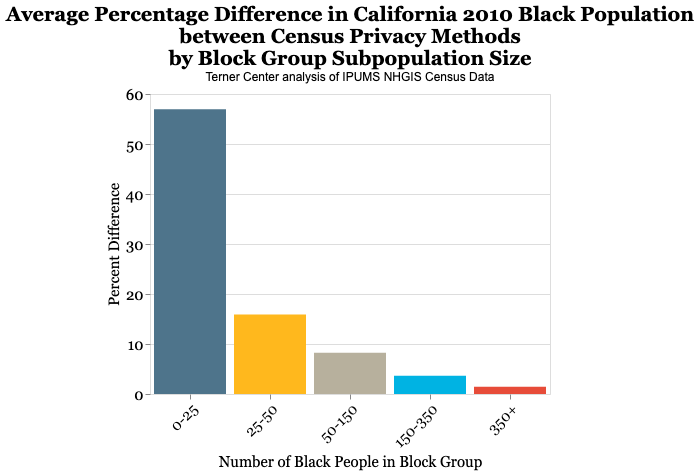

In [17]:
#figure 2
alt.Chart(black_percent_change).mark_bar().encode(
    alt.X('Population Bins:O',title="Number of Black People in Block Group", sort=['0-25', '25-50', '50-150', "150-350","350+"],axis=alt.Axis( labelAngle=-45)),
    alt.Y('pct_change_absolute_value mean',title="Percent Difference"),color=alt.Color('Population Bins:O',title="",legend=None,scale=alt.Scale(domain=['0-25', '25-50', '50-150', "150-350","350+"],range=["#4E748B","#FFB81D","#B7B09D","#00B3E3","#E74C39"]))).properties(
    title={
      "text": ["Average Percentage Difference in California 2010 Black Population",
               "between Census Privacy Methods"," by Block Group Subpopulation Size"],
    "subtitle":["Terner Center analysis of IPUMS NHGIS Census Data"]}).configure_title(fontSize=20,anchor="middle",font="Georgia").configure_legend(direction="vertical",labelLimit= 0,titleLimit=0,titleFontSize=18,
labelFontSize=20,labelFont="Georgia",titleFont="Georgia",orient="bottom").configure_axis(domain=False,labelFont='Georgia',titleFont='Georgia',titleFontWeight="normal",labelFontSize=15,titleFontSize=15).properties(
    width=400
)